## Dog Breed Classifier 
## 전이학습, (Transfer Learning)

In [1]:
!conda list scikit-learn

# packages in environment at C:\ProgramData\Anaconda3\envs\cvtf2:
#
# Name                    Version                   Build  Channel
scikit-learn              0.23.2           py37h47e9c7a_0  


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
from numpy.random import rand

pd.options.display.max_colwidth = 800

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3

## Load Dataset

In [5]:
train_folder = 'dog-breed-identification/train/'
test_folder = 'dog-breed-identification/test/'

In [6]:
data_labels = pd.read_csv('dog-breed-identification/labels.csv')

In [7]:
data_labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [8]:
target_labels = data_labels['breed']
len(set(target_labels))

120

## Prepare Labels

In [10]:
labels_ohe_names = pd.get_dummies(target_labels, sparse=True)
labels_ohe = np.asarray(labels_ohe_names)

In [11]:
print(labels_ohe.shape)
print(labels_ohe[:2])

(10222, 120)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]


In [13]:
data_labels['image_path'] = data_labels \
    .apply(lambda row: (train_folder + row['id'] + '.jpg'), axis=1)

In [15]:
data_labels.head()

id             breed  \
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull   
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo   
2  001cdf01b096e06d78e9e5112d419397          pekinese   
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick   
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever   

                                                            image_path  
0  dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg  
1  dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg  
2  dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg  
3  dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg  
4  dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg

## Prepare Train-Test Datasets

In [16]:
train_data = np.array([img_to_array(load_img(img, target_size=(299, 299))) \
                       for img in data_labels['image_path'].values.tolist()]).astype('float32')

In [17]:
train_data.shape

(10222, 299, 299, 3)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(train_data, target_labels, 
                                                   test_size=0.3,
                                                   stratify=np.array(target_labels),
                                                   random_state=55)

In [19]:
x_train.shape, x_test.shape

((7155, 299, 299, 3), (3067, 299, 299, 3))

In [20]:
# Prepare Validation Datasets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                 test_size=0.15,
                                                 stratify=np.array(y_train),
                                                 random_state=55)

In [21]:
x_train.shape, x_val.shape

((6081, 299, 299, 3), (1074, 299, 299, 3))

In [22]:
# Prepare target variables for train, test and validation datasets
y_train_ohe = pd.get_dummies(y_train.reset_index(drop=True))
y_val_ohe = pd.get_dummies(y_val.reset_index(drop=True))
y_test_ohe = pd.get_dummies(y_test.reset_index(drop=True))

In [23]:
y_train_ohe.shape, y_val_ohe.shape, y_test_ohe.shape

((6081, 120), (1074, 120), (3067, 120))

## Data (image) Augmentation

In [24]:
BATCH_SIZE = 32

In [25]:
# Create train generator.
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip='true')
train_generator = train_datagen.flow(x_train, y_train_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=1)

In [27]:
# Create validation generator
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(x_val, y_val_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=1)

## Prepare Deep Learning Classifier
- Load InceptionV3
- Add additional custom layers on top of InceptionV3 to prepare custom classifier

In [28]:
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

87916544/87910968 [==============================] - 2s 0us/step


In [ ]:
base_inception.summary()

In [31]:
y_train_ohe.shape[1]

120

In [32]:
# Add a global spatial averasge pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
total_classes = y_train_ohe.shape[1]
predictions = Dense(total_classes, activation='softmax')(out)

In [33]:
model = Model(inputs=base_inception.input, outputs=predictions)

In [ ]:
model.summary()

In [35]:
# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False

In [36]:
# model compile
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

## Model Training

In [40]:
train_steps_per_epoch = x_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = y_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                             steps_per_epoch=train_steps_per_epoch,
                             validation_data=val_generator,
                             validation_steps=val_steps_per_epoch,
                             epochs=2,
                             verbose=1)

Epoch 1/2
190/190 [==============================] - 312s 2s/step - loss: 0.8601 - accuracy: 0.7934 - val_loss: 0.5414 - val_accuracy: 0.8722
Epoch 2/2
190/190 [==============================] - 304s 2s/step - loss: 0.6585 - accuracy: 0.8172 - val_loss: 0.4579 - val_accuracy: 0.8665


## Save the Model

In [42]:
model.save('dog_breed.hdf5')

## Visualize Model Performance

In [45]:
history.history

{'loss': [0.8600926995277405, 0.658491313457489],
 'accuracy': [0.7933542728424072, 0.8171598315238953],
 'val_loss': [0.5414266586303711, 0.4578820466995239],
 'val_accuracy': [0.8721590638160706, 0.8664772510528564]}

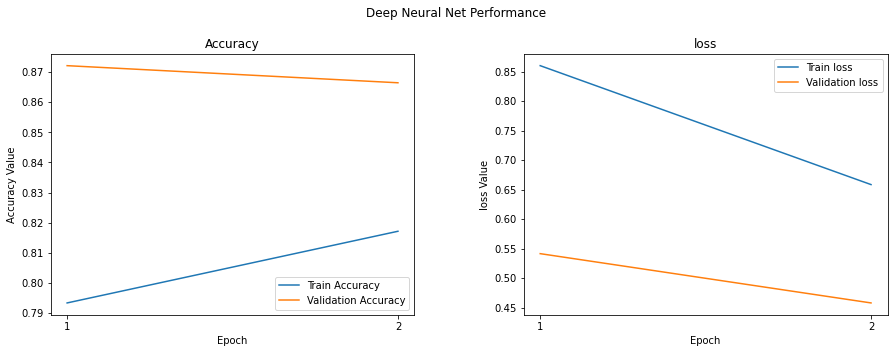

In [49]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1, 3))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc='best')

ax2.plot(epochs, history.history['loss'], label='Train loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('loss')
l2 = ax2.legend(loc='best')

## Test Model Performance

In [41]:
x_test /= 255.

In [50]:
test_predictions = model.predict(x_test)

In [51]:
predictions = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)

In [52]:
predictions.head(3)

affenpinscher  afghan_hound  african_hunting_dog      airedale  \
0       0.000038      0.000013             0.000028  5.188081e-07   
1       0.000177      0.000444             0.000110  1.147507e-04   
2       0.000059      0.000025             0.000119  2.904891e-06   

   american_staffordshire_terrier   appenzeller  australian_terrier   basenji  \
0                        0.000213  2.025496e-06        3.805070e-08  0.000009   
1                        0.000073  2.883539e-04        1.484025e-05  0.000062   
2                        0.000038  9.910085e-07        1.325298e-04  0.000017   

     basset    beagle  ...  toy_poodle  toy_terrier    vizsla  walker_hound  \
0  0.000002  0.000004  ...    0.000003     0.000069  0.000033      0.000003   
1  0.000176  0.000057  ...    0.000080     0.000559  0.000042      0.000031   
2  0.000003  0.000015  ...    0.000203     0.000106  0.000039      0.000003   

   weimaraner  welsh_springer_spaniel  west_highland_white_terrier   whippet  \
0    0.000027                0.000007                     0.000075  0.000016   
1    0.000073                0.000075                     0.000175  0.000041   
2    0.000045                0.000005                     0.000387  0.000011   

   wire-haired_fox_terrier  yorkshire_terrier  
0                 0.000002           0.000059  
1                 0.000271           0.000403  
2                 0.000018           0.000911  

[3 rows x 120 columns]

In [53]:
test_labels = list(y_test)
predictions = list(predictions.idxmax(axis=1))
predictions[:10]

['pug',
 'malamute',
 'dandie_dinmont',
 'scottish_deerhound',
 'boxer',
 'brabancon_griffon',
 'toy_poodle',
 'dhole',
 'curly-coated_retriever',
 'malamute']

## Analyze Test Performance

In [54]:
import model_evaluation_utils as meu

In [55]:
meu.get_metrics(true_labels=test_labels, predicted_labels=predictions)

Accuracy: 0.8644
Precision: 0.8759
Recall: 0.8644
F1 Score: 0.8604


In [ ]:
meu.display_classification_report(true_labels=test_labels,
                                 predicted_labels=predictions,
                                 classes=list(labels_ohe_names.columns))

In [ ]:
meu.display_confusion_matrix(true_labels=test_labels,
                                 predicted_labels=predictions,
                                 classes=list(labels_ohe_names.columns))

## Visualize Model Performance

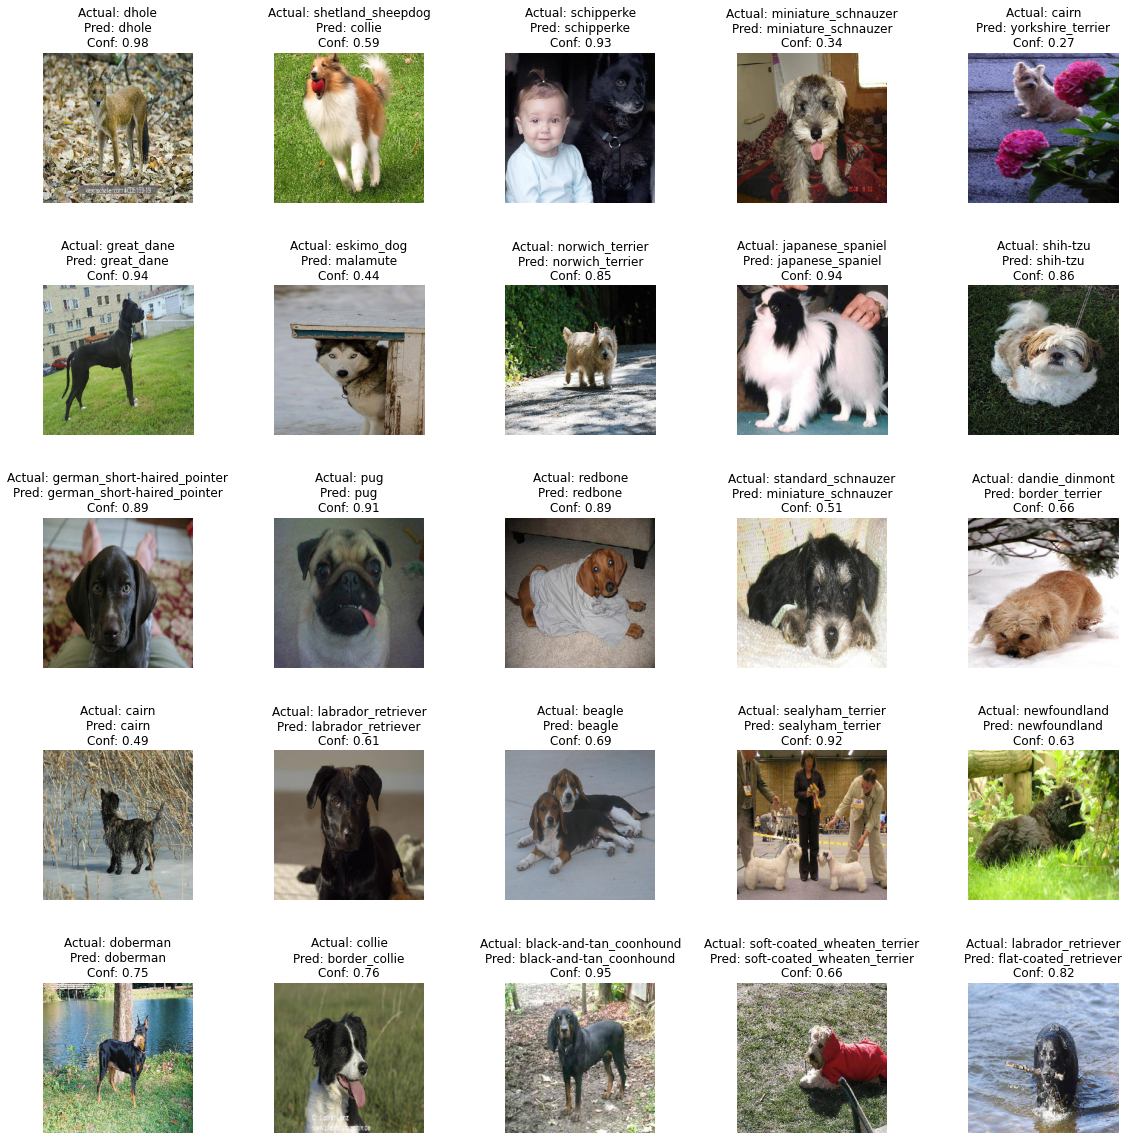

In [61]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)
batch_size = 25
dataset = x_test

label_dict = dict(enumerate(labels_ohe_names.columns.values))
model_input_shape = (1, 299, 299, 3)
random_batch_indx = np.random.permutation(np.arange(0, len(dataset)))[:batch_size]

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual_label = np.array(y_test)[random_batch_indx[img_idx]]
        predicion = model.predict(dataset[random_batch_indx[img_idx]]. \
                                 reshape(model_input_shape))[0]
        label_idx = np.argmax(predicion)
        predicted_label = label_dict.get(label_idx)
        conf = round(predicion[label_idx], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+actual_label +'\nPred: ' \
                           + predicted_label + '\nConf: ' + str(conf))
        ax[i][j].imshow(dataset[random_batch_indx[img_idx]])
        img_idx += 1
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)